In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
input_data = pd.read_csv('./관련자료/만족도모델_입력데이터.csv', encoding='cp949')

input_data

In [3]:
# 평가 항목별 정보

dline_rate = {'최솟값' : 35, '최댓값' : 90, '망대 여부' : True, '퍼지 여부' : False, '배점' : 13}
dline_delay = {'최솟값' : 4, '최댓값' : 20, '망대 여부' : False, '퍼지 여부' : False, '배점' : 12}
flaw = {'최솟값' : 1, '최댓값' : 8, '망대 여부' : False, '퍼지 여부' : False, '배점' : 9}

quality = {'최솟값' : 1, '최댓값' : 6, '망대 여부' : True, '퍼지 여부' : True, '배점' : 12}
price = {'최솟값' : 1, '최댓값' : 5, '망대 여부' : True, '퍼지 여부' : True, '배점' : 6}
service = {'최솟값' : 0, '최댓값' : 6, '망대 여부' : True, '퍼지 여부' : True, '배점' : 6}
post = {'최솟값' : 1, '최댓값' : 5, '망대 여부' : True, '퍼지 여부' : True, '배점' : 6}

item_rate = {'최솟값' : 43, '최댓값' : 90, '망대 여부' : True, '퍼지 여부' : False, '배점' : 8}
as_period = {'최솟값' : 3, '최댓값' : 15, '망대 여부' : False, '퍼지 여부' : False, '배점' : 8}
fraud_penalty  = {'최솟값' : 3, '최댓값' : 120, '망대 여부' : False, '퍼지 여부' : False, '배점' : 10}
trade_penalty  = {'최솟값' : 6, '최댓값' : 130, '망대 여부' : False, '퍼지 여부' : False, '배점' : 10}


col_option = pd.DataFrame([dline_rate, dline_delay, flaw, quality, price, service, post, item_rate, as_period, fraud_penalty, trade_penalty])
col_option.index = input_data.columns[1:]
col_option

,최솟값,최댓값,망대 여부,퍼지 여부,배점
납기준수율,35,90,True,False,13
평균 납기지체일수,4,20,False,False,12
하자처리 건수,1,8,False,False,9
품질 만족도,1,6,True,True,12
가격 만족도,1,5,True,True,6
서비스 만족도,0,6,True,True,6
사후 만족도,1,5,True,True,6
납품품목비율,43,90,True,False,8
하자처리 기간,3,15,False,False,8
부정당업자 제재기간,3,120,False,False,10


In [4]:
# 사다리꼴 퍼지수 
pts_list = [(0, 0, 12.5, 18.75), (8.33, 14.58, 27.08, 33.33), (22.91, 29.16, 41.66, 47.91), (37.49, 43.74, 56.24, 62.49), 
            (52.07, 58.32, 70.82, 77.07), (66.65, 72.9, 85.4, 91.65), (81.23, 87.48, 100, 100)]

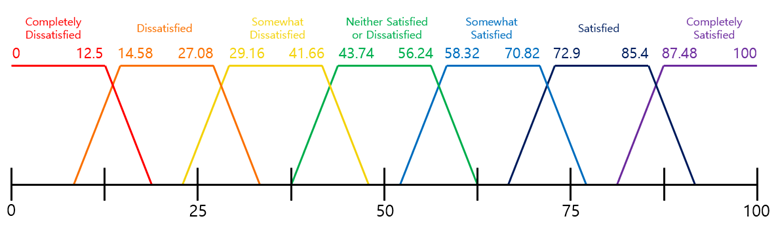

In [5]:
# 사다리꼴 그리기
def plot_trape(fuzzy_score, col='red'):
    plt.plot((fuzzy_score[0], fuzzy_score[1]), (0, height), color=col, label=company_name[-1])
    plt.plot((fuzzy_score[1], fuzzy_score[2]), (height, height), color=col)
    plt.plot((fuzzy_score[2], fuzzy_score[3]), (height, 0), color=col)

In [6]:
def tuple_to_str(tup):
    return f'({tup[0]:.3f}, {tup[1]:.3f}, {tup[2]:.3f}, {tup[3]:.3f})'

# 1. 고정 스프레드 + 최대/최소 수정

In [7]:
class evaluation_model1:   
    # 구간 연산 - 뺄셈 함수: A - B
    def intv_sub(self, A, B):
        num1 = A[0] - B[1]
        num2 = A[1] - B[0]
        return num1, num2
    
    # 평가항목에 대한 점수 계산
    def col_score(self, y_i, y_min, y_max, isMangdae, isFuzzy):
        if isMangdae:    # 망대 특성인 경우
            if isFuzzy:  # Fuzzy 데이터인 경우
                # elementwise 연산를 위해 nunmpy array로 변환
                y_min = np.array(y_min)
                y_max = np.array(y_max)
                y_i = np.array(y_i)
                
                bunja = self.intv_sub(y_i, y_min)
                bunmo = self.intv_sub(y_max, y_min)
                cases = [a/b for a in bunja for b in bunmo]       # 분자/분모의 구간 연산
                score = (min(cases), max(cases))

                return score

            else:       # Crisp 데이터인 경우
                score = (y_i - y_min) / (y_max - y_min)
                return (score, score)


        else:    # 망소 특성인 경우 -> 1에서 뺀 값을 반환
            if isFuzzy:  # Fuzzy 데이터인 경우
                # elementwise 연상를 위해 nunmpy array로 변환
                y_min = np.array(y_min)
                y_max = np.array(y_max)
                y_i = np.array(y_i)

                bunja = self.intv_sub(y_i, y_min)
                bunmo = self.intv_sub(y_max, y_min)
                cases = [a/b for a in bunja for b in bunmo]        # 분자/분모의 구간 연산
                score = (1-max(cases), 1-min(cases))

                return score

            else:       # Crisp 데이터인 경우
                score = (y_i - y_min) / (y_max - y_min)
                return (1-score, 1-score)
    
    # 종합 사후평가 점수 계산
    def get_score(self, data):
        total_score = np.array([0., 0.])
        for key, value in dict(data[1:]).items():   # key : 평가항목명, value : 해당 항목 관측값
            info = col_option.loc[key]               # 해당 항목 정보
            y_i = value
            y_min = info['최솟값']; y_max = info['최댓값']
            isMangdae = info['망대 여부']; isFuzzy = info['퍼지 여부']
            allot = info['배점']
            if isFuzzy:
                y_i = pts_list[y_i][1:3]
                y_min = pts_list[y_min][1:3]; y_max = pts_list[y_max][1:3]
            
            total_score += np.array(self.col_score(y_i, y_min, y_max, isMangdae, isFuzzy)) * allot
            
        return total_score / 100

In [8]:
model1 = evaluation_model1()

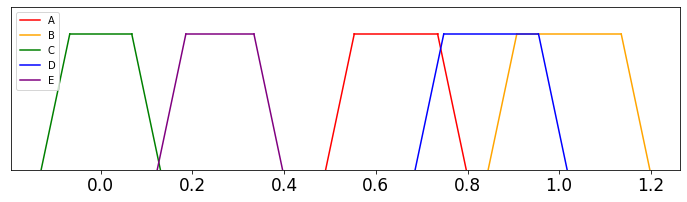

In [9]:
# 결과 확인
fuzzy_scores = []
company_names = []
height = 1
cols = ['red', 'orange', 'green', 'blue', 'purple']

plt.figure(figsize=(12, 3))
# plt.xlim(-0.15, 1.12)
plt.ylim(0, height+0.2)
plt.xticks(size=17)
plt.yticks([])


for i, data in input_data.iterrows():
    company_name = data[0]
    company_names.append(company_name)
    
    score = model1.get_score(data)
    fuzzy_score = (score[0]-0.0625, score[0], score[1], score[1]+0.0625)
    fuzzy_scores.append(fuzzy_score)
    
    plot_trape(fuzzy_score, cols[i])

plt.legend(loc='upper left')   
plt.show()    

In [10]:
pd.DataFrame({'기업명' : company_names,
              'score' : [tuple_to_str(s) for s in fuzzy_scores]})

,기업명,score
0,기업 A,"(0.490, 0.553, 0.735, 0.797)"
1,기업 B,"(0.845, 0.907, 1.135, 1.198)"
2,기업 C,"(-0.130, -0.068, 0.068, 0.130)"
3,기업 D,"(0.686, 0.748, 0.955, 1.017)"
4,기업 E,"(0.123, 0.186, 0.334, 0.397)"


**0과 1 사이로 보정**

In [11]:
def correct_over_0(num):
    return max(0, num)

def correct_under_1(num):
    return min(1, num)

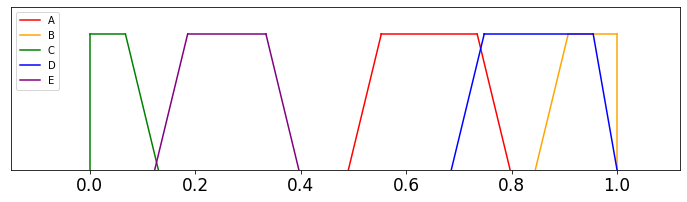

In [12]:
# 결과 확인
fuzzy_scores = []
company_names = []
height = 1
cols = ['red', 'orange', 'green', 'blue', 'purple']

plt.figure(figsize=(12, 3))
plt.xlim(-0.15, 1.12)
plt.ylim(0, height+0.2)
plt.xticks(size=17)
plt.yticks([])


for i, data in input_data.iterrows():
    company_name = data[0]
    company_names.append(company_name)
    
    score = model1.get_score(data)
    fuzzy_score = (score[0]-0.0625, score[0], score[1], score[1]+0.0625)
    fuzzy_score = tuple(map(correct_over_0, fuzzy_score))
    fuzzy_score = tuple(map(correct_under_1, fuzzy_score))
    fuzzy_scores.append(fuzzy_score)
    
    plot_trape(fuzzy_score, cols[i])

plt.legend(loc='upper left')   
plt.show()    

In [13]:
pd.DataFrame({'기업명' : company_names,
              'score' : [tuple_to_str(s) for s in fuzzy_scores]})

,기업명,score
0,기업 A,"(0.490, 0.553, 0.735, 0.797)"
1,기업 B,"(0.845, 0.907, 1.000, 1.000)"
2,기업 C,"(0.000, 0.000, 0.068, 0.130)"
3,기업 D,"(0.686, 0.748, 0.955, 1.000)"
4,기업 E,"(0.123, 0.186, 0.334, 0.397)"


# 2. function principle + 최대/최소 수정

In [14]:
class evaluation_model2:
    # 퍼지 뺄셈: A - B
    def fuzzy_sub(self, A, B):
        num1 = A[0] - B[3]
        num2 = A[1] - B[2]
        num3 = A[2] - B[1]
        num4 = A[3] - B[0]
        return num1, num2, num3, num4
    
    # 퍼지 나눗셈: A / B
    def fuzzy_div(self, A, B):
        # safe division
        B = [n + 1e-9 if n == 0 else n for n in B]
        num1 = min([A[0]/B[0], A[0]/B[3], A[3]/B[0], A[3]/B[3]])
        num2 = min([A[1]/B[1], A[2]/B[2]])
        num3 = max([A[1]/B[1], A[2]/B[2]])
        num4 = max([A[0]/B[0], A[0]/B[3], A[3]/B[0], A[3]/B[3]])
        return num1, num2, num3, num4
    
    # 평가항목에 대한 점수 계산
    def col_score(self, y_i, y_min, y_max, isMangdae, isFuzzy):
        if isMangdae:    # 망대 특성인 경우
            if isFuzzy:  # Fuzzy 데이터인 경우
                # elementwise 연산를 위해 nunmpy array로 변환
                y_min = np.array(y_min)
                y_max = np.array(y_max)
                y_i = np.array(y_i)

                bunja = self.fuzzy_sub(y_i, y_min)
                bunmo = self.fuzzy_sub(y_max, y_min)
                score = self.fuzzy_div(bunja, bunmo)

                return score

            else:       # Crisp 데이터인 경우
                score = (y_i - y_min) / (y_max - y_min)
                return (score, score, score, score)


        else:    # 망소 특성인 경우 -> 1에서 뺀 값을 반환
            if isFuzzy:  # Fuzzy 데이터인 경우
                # elementwise 연상를 위해 nunmpy array로 변환
                y_min = np.array(y_min)
                y_max = np.array(y_max)
                y_i = np.array(y_i)

                bunja = self.fuzzy_sub(y_i, y_min)
                bunmo = self.fuzzy_sub(y_max, y_min)
                score = self.fuzzy_div(bunja, bunmo)

                return (1 - score)[::-1]

            else:       # Crisp 데이터인 경우
                score = (y_i - y_min) / (y_max - y_min)
                return (1-score, 1-score, 1-score, 1-score)
        
    # 종합 사후평가 점수 계산
    def get_score(self, data):
        total_score = np.array([0., 0., 0., 0.])
        for key, value in dict(data[1:]).items():   # key : 평가항목명, value : 해당 항목 관측값
            info = col_option.loc[key]               # 해당 항목 정보
            y_i = value
            y_min = info['최솟값']; y_max = info['최댓값']
            isMangdae = info['망대 여부']; isFuzzy = info['퍼지 여부']
            allot = info['배점']
            if isFuzzy:
                y_i = pts_list[y_i]
                y_min = pts_list[y_min]; y_max = pts_list[y_max]

            total_score += np.array(self.col_score(y_i, y_min, y_max, isMangdae, isFuzzy)) * allot

        return total_score / 100

In [15]:
model2 = evaluation_model2()

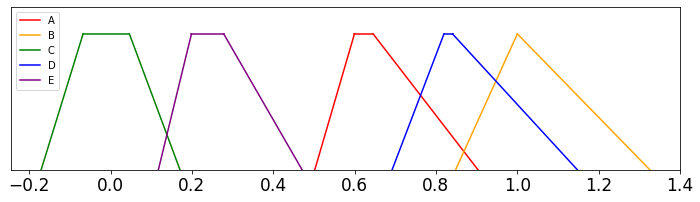

In [16]:
fuzzy_scores = []
company_names = []
height = 1
cols = ['red', 'orange', 'green', 'blue', 'purple']

plt.figure(figsize=(12, 3))
# plt.xlim(0, 1.05)
plt.ylim(0, height+0.2)
plt.xticks(size=17)
plt.yticks([])

scores = []
for i, data in input_data.iterrows():
    company_name = data[0]
    company_names.append(company_name)
    
    fuzzy_score = model2.get_score(data)
    fuzzy_scores.append(fuzzy_score)
    
    plot_trape(fuzzy_score, cols[i])
    
plt.legend(loc='upper left')   
plt.show()   

In [17]:
pd.DataFrame({'기업명' : company_names,
              'score' : [tuple_to_str(s) for s in fuzzy_scores]})

,기업명,score
0,기업 A,"(0.502, 0.600, 0.645, 0.903)"
1,기업 B,"(0.848, 1.000, 1.000, 1.326)"
2,기업 C,"(-0.171, -0.068, 0.046, 0.171)"
3,기업 D,"(0.692, 0.820, 0.841, 1.148)"
4,기업 E,"(0.117, 0.199, 0.278, 0.471)"


**0과 1 사이로 보정**

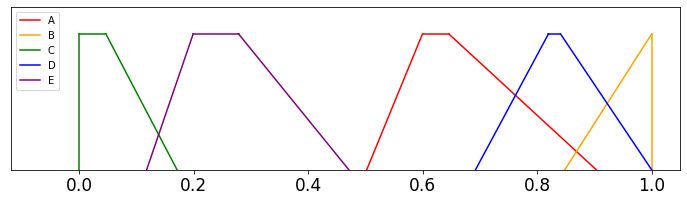

In [18]:
fuzzy_scores = []
company_names = []
height = 1
cols = ['red', 'orange', 'green', 'blue', 'purple']

plt.figure(figsize=(12, 3))
plt.xlim(-0.12, 1.05)
plt.ylim(0, height+0.2)
plt.xticks(size=17)
plt.yticks([])

scores = []
for i, data in input_data.iterrows():
    company_name = data[0]
    company_names.append(company_name)
    
    fuzzy_score = model2.get_score(data)
    fuzzy_score = tuple(map(correct_over_0, fuzzy_score))
    fuzzy_score = tuple(map(correct_under_1, fuzzy_score))
    fuzzy_scores.append(fuzzy_score)
    
    plot_trape(fuzzy_score, cols[i])
    
plt.legend(loc='upper left')   
plt.show()   

In [19]:
pd.DataFrame({'기업명' : company_names,
              'score' : [tuple_to_str(s) for s in fuzzy_scores]})

,기업명,score
0,기업 A,"(0.502, 0.600, 0.645, 0.903)"
1,기업 B,"(0.848, 1.000, 1.000, 1.000)"
2,기업 C,"(0.000, 0.000, 0.046, 0.171)"
3,기업 D,"(0.692, 0.820, 0.841, 1.000)"
4,기업 E,"(0.117, 0.199, 0.278, 0.471)"


# 최대/최소 수정 전 버전 (보관용)

## 고정 스프레드 + 최대/최소 MAS

In [ ]:
class evaluation_model:
    def __init__(self):
        # 평가항목별 정보
        self.dline_rate = {'항목' : '납기준수율', '최솟값' : 0, '최댓값' : 100,
                           '망대 여부' : True, '퍼지 여부' : False, '배점' : 13}
        self.dline_delay = {'항목' : '평균 납기지체일수', '최솟값' : 0, '최댓값' : 30,
                            '망대 여부' : False, '퍼지 여부' : False, '배점' : 12}
        self.flaw = {'항목' : '하자처리 건수', '최솟값' : 0, '최댓값' : 8,
                     '망대 여부' : False, '퍼지 여부' : False, '배점' : 9}
        self.quality = {'항목' : '품질 만족도', '최솟값' : 0, '최댓값' : 100,
                        '망대 여부' : True, '퍼지 여부' : True, '배점' : 12}
        self.price = {'항목' : '가격 만족도', '최솟값' : 0, '최댓값' : 100,
                      '망대 여부' : True, '퍼지 여부' : True, '배점' : 6}
        self.service = {'항목' : '서비스 만족도', '최솟값' : 0, '최댓값' : 100,
                        '망대 여부' : True, '퍼지 여부' : True, '배점' : 6}
        self.post = {'항목' : '사후 만족도', '최솟값' : 0, '최댓값' : 100,
                     '망대 여부' : True, '퍼지 여부' : True, '배점' : 6}
        self.item_rate = {'항목' : '납품품목비율', '최솟값' : 0, '최댓값' : 100,
                          '망대 여부' : True, '퍼지 여부' : False, '배점' : 8}
        self.as_period = {'항목' : '하자처리기간', '최솟값' : 3, '최댓값' : 24,
                          '망대 여부' : False, '퍼지 여부' : False, '배점' : 8}
        self.fraud_penalty  = {'항목' : '부정당업자 제재기간', '최솟값' : 0, '최댓값' : 270,
                               '망대 여부' : False, '퍼지 여부' : False, '배점' : 10}
        self.trade_penalty  = {'항목' : '거래정지 기간', '최솟값' : 0, '최댓값' : 270,
                               '망대 여부' : False, '퍼지 여부' : False, '배점' : 10}

        # 평가항목 리스트
        self.list = {'납기준수율' : self.dline_rate, '평균 납기지체일수' : self.dline_delay, '하자처리 건수' : self.flaw,
                     '품질 만족도' : self.quality, '가격 만족도' : self.price, '서비스 만족도' : self.service,
                     '사후 만족도' : self.post, '납품품목비율' : self.item_rate, '하자처리 기간' : self.as_period,
                     '부정당업자 제재기간' : self.fraud_penalty, '거래정지 기간' : self.trade_penalty}
        
        # 사다리꼴 퍼지수 피크 구간
        self.pts_list = [(0, 12.5), (14.58, 27.08), (29.16, 41.66), (43.74, 56.24), (58.32, 70.82), (72.9, 85.4), (87.48, 100)]
    
    # 구간 연산 - 뺄셈 함수: A - B
    def intv_sub(self, A, B):
        num1 = A[0] - B[1]
        num2 = A[1] - B[0]
        return num1, num2
    
    # 만족도 계산
    def get_fuzzy_score(self, y_i, y_min, y_max, isMangdae, isFuzzy):
        if isMangdae:    # 망대 특성인 경우
            if isFuzzy:  # Fuzzy 데이터인 경우
                # elementwise 연산를 위해 nunmpy array로 변환
                y_min = np.array([y_min, y_min])
                y_max = np.array([y_max, y_max])
                y_i = np.array(y_i)
                if np.mean(y_i) < np.mean(y_min):
                    score = (0, 0)
                elif np.mean(y_i) > np.mean(y_max):
                    score = (1, 1)
                else:
                    bunja = self.intv_sub(y_i, y_min)
                    bunmo = self.intv_sub(y_max, y_min)
                    cases = [a/b for a in bunja for b in bunmo]       # 분자/분모의 구간 연산
                    score = (min(cases), max(cases))

                return score

            else:       # Crisp 데이터인 경우
                if y_i <= y_min:
                    score = 0
                elif y_i >= y_max:
                    score = 1
                else:
                    score = (y_i - y_min) / (y_max - y_min)

                return (score, score)


        else:    # 망소 특성인 경우 -> 1에서 뺀 값을 반환
            if isFuzzy:  # Fuzzy 데이터인 경우
                # elementwise 연상를 위해 nunmpy array로 변환
                y_min = np.array([y_min, y_min])
                y_max = np.array([y_max, y_max])
                y_i = np.array(y_i)

                if np.mean(y_i) < np.mean(y_min):
                    score = (1, 1)
                elif np.mean(y_i) > np.mean(y_max):
                    score = (0, 0)
                else:
                    bunja = self.intv_sub(y_i, y_min)
                    bunmo = self.intv_sub(y_max, y_min)
                    cases = [a/b for a in bunja for b in bunmo]        # 분자/분모의 구간 연산
                    score = (1-max(cases), 1-min(cases))

                return score

            else:       # Crisp 데이터인 경우
                if y_i <= y_min:
                    score = 0
                elif y_i >= y_max:
                    score = 1
                else:
                    score = (y_i - y_min) / (y_max - y_min)

                return (1-score, 1-score)
    
    def get_score(self, data):
        total_score = np.array([0., 0.])
        for key, value in dict(data[1:]).items():   # key : 평가항목명, value : 해당 항목 관측값
            info = self.list[key]                    # 해당 항목 정보
            y_i = value
            y_min = info['최솟값']; y_max = info['최댓값']
            isMangdae = info['망대 여부']; isFuzzy = info['퍼지 여부']
            allot = info['배점']
            if isFuzzy:
                y_i = self.pts_list[y_i]
            
            total_score += np.array(self.get_fuzzy_score(y_i, y_min, y_max, isMangdae, isFuzzy)) * allot
            
        return total_score / 100

In [ ]:
model1 = evaluation_model()

In [ ]:
# 결과 확인
scores = []
scores_with_spread = []
company_names = []
height = 1
cols = ['red', 'orange', 'green', 'blue', 'purple']

plt.figure(figsize=(12, 3))
plt.xlim(0, 1.05)
plt.ylim(0, height+0.2)
plt.xticks(size=17)
plt.yticks([])


for i in range(len(input_data)):
    data = input_data.iloc[i]
    company_name = data[0]
    score = model1.get_score(data)
    score_with_spread = score + np.array([-0.0625, 0.0625])
    
    company_names.append(company_name)
    scores.append(score) 
    scores_with_spread.append(score_with_spread)
    
    plot_trape(score, score_with_spread, cols[i])

plt.legend(loc='upper left')   
plt.show()    

In [ ]:
temp = [(scores_with_spread[i][0], scores[i][0], scores[i][1], scores_with_spread[i][1]) for i in range(5)]
pd.DataFrame({'기업명' : company_names,
              'score' : list(map(tuple_to_str, temp))})

## function principle + 최대/최소 MAS

In [ ]:
class evaluation_model2:
    def __init__(self):
        # 평가항목별 정보
        self.dline_rate = {'항목' : '납기준수율', '최솟값' : 0, '최댓값' : 100,
                           '망대 여부' : True, '퍼지 여부' : False, '배점' : 13}
        self.dline_delay = {'항목' : '평균 납기지체일수', '최솟값' : 0, '최댓값' : 30,
                            '망대 여부' : False, '퍼지 여부' : False, '배점' : 12}
        self.flaw = {'항목' : '하자처리 건수', '최솟값' : 0, '최댓값' : 8,
                     '망대 여부' : False, '퍼지 여부' : False, '배점' : 9}
        self.quality = {'항목' : '품질 만족도', '최솟값' : 0, '최댓값' : 100,
                        '망대 여부' : True, '퍼지 여부' : True, '배점' : 12}
        self.price = {'항목' : '가격 만족도', '최솟값' : 0, '최댓값' : 100,
                      '망대 여부' : True, '퍼지 여부' : True, '배점' : 6}
        self.service = {'항목' : '서비스 만족도', '최솟값' : 0, '최댓값' : 100,
                        '망대 여부' : True, '퍼지 여부' : True, '배점' : 6}
        self.post = {'항목' : '사후 만족도', '최솟값' : 0, '최댓값' : 100,
                     '망대 여부' : True, '퍼지 여부' : True, '배점' : 6}
        self.item_rate = {'항목' : '납품품목비율', '최솟값' : 0, '최댓값' : 100,
                          '망대 여부' : True, '퍼지 여부' : False, '배점' : 8}
        self.as_period = {'항목' : '하자처리기간', '최솟값' : 3, '최댓값' : 24,
                          '망대 여부' : False, '퍼지 여부' : False, '배점' : 8}
        self.fraud_penalty  = {'항목' : '부정당업자 제재기간', '최솟값' : 0, '최댓값' : 270,
                               '망대 여부' : False, '퍼지 여부' : False, '배점' : 10}
        self.trade_penalty  = {'항목' : '거래정지 기간', '최솟값' : 0, '최댓값' : 270,
                               '망대 여부' : False, '퍼지 여부' : False, '배점' : 10}

        # 평가항목 리스트
        self.list = {'납기준수율' : self.dline_rate, '평균 납기지체일수' : self.dline_delay, '하자처리 건수' : self.flaw,
                     '품질 만족도' : self.quality, '가격 만족도' : self.price, '서비스 만족도' : self.service,
                     '사후 만족도' : self.post, '납품품목비율' : self.item_rate, '하자처리 기간' : self.as_period,
                     '부정당업자 제재기간' : self.fraud_penalty, '거래정지 기간' : self.trade_penalty}
        
        # 사다리꼴 퍼지수 피크 구간
        self.pts_list = [(0, 0, 12.5, 18.75), (8.33, 14.58, 27.08, 33.33), (22.91, 29.16, 41.66, 47.91), (37.49, 43.74, 56.24, 62.49), 
                         (52.07, 58.32, 70.82, 77.07), (66.65, 72.9, 85.4, 91.65), (81.23, 87.48, 100, 100)]
    
    # 퍼지 뺄셈: A - B
    def fuzzy_sub(self, A, B):
        num1 = A[0] - B[3]
        num2 = A[1] - B[2]
        num3 = A[2] - B[1]
        num4 = A[3] - B[0]
        return num1, num2, num3, num4
    
    # 퍼지 나눗셈: A / B
    def fuzzy_div(self, A, B):
        # safe division
        B = [n + 1e-9 if n == 0 else n for n in B]
        num1 = min([A[0]/B[0], A[0]/B[3], A[3]/B[0], A[3]/B[3]])
        num2 = min([A[1]/B[1], A[2]/B[2]])
        num3 = max([A[1]/B[1], A[2]/B[2]])
        num4 = max([A[0]/B[0], A[0]/B[3], A[3]/B[0], A[3]/B[3]])
        return num1, num2, num3, num4
    
    # 만족도 계산
    def get_fuzzy_score(self, y_i, y_min, y_max, isMangdae, isFuzzy):
        if isMangdae:    # 망대 특성인 경우
            if isFuzzy:  # Fuzzy 데이터인 경우
                # elementwise 연산를 위해 nunmpy array로 변환
                y_min = np.array([y_min, y_min, y_min, y_min])
                y_max = np.array([y_max, y_max, y_max, y_max])
                y_i = np.array(y_i)
                if np.mean(y_i) < np.mean(y_min):
                    score = (0, 0, 0, 0)
                elif np.mean(y_i) > np.mean(y_max):
                    score = (1, 1, 1, 1)
                else:
                    bunja = self.fuzzy_sub(y_i, y_min)
                    bunmo = self.fuzzy_sub(y_max, y_min)
                    score = self.fuzzy_div(bunja, bunmo)

                return score

            else:       # Crisp 데이터인 경우
                if y_i <= y_min:
                    score = 0
                elif y_i >= y_max:
                    score = 1
                else:
                    score = (y_i - y_min) / (y_max - y_min)

                return (score, score, score, score)


        else:    # 망소 특성인 경우 -> 1에서 뺀 값을 반환
            if isFuzzy:  # Fuzzy 데이터인 경우
                # elementwise 연상를 위해 nunmpy array로 변환
                y_min = np.array([y_min, y_min, y_min, y_min])
                y_max = np.array([y_max, y_max, y_max, y_max])
                y_i = np.array(y_i)

                if np.mean(y_i) < np.mean(y_min):
                    score = (1, 1, 1, 1)
                elif np.mean(y_i) > np.mean(y_max):
                    score = (0, 0, 0, 0)
                else:
                    bunja = self.fuzzy_sub(y_i, y_min)
                    bunmo = self.fuzzy_sub(y_max, y_min)
                    score = self.fuzzy_div(bunja, bunmo)

                return (1 - score)[::-1]

            else:       # Crisp 데이터인 경우
                if y_i <= y_min:
                    score = 0
                elif y_i >= y_max:
                    score = 1
                else:
                    score = (y_i - y_min) / (y_max - y_min)

                return (1-score, 1-score, 1-score, 1-score)
    
    def get_score(self, data):
        total_score = np.array([0., 0., 0., 0.])
        for key, value in dict(data[1:]).items():   # key : 평가항목명, value : 해당 항목 관측값
            info = self.list[key]                    # 해당 항목 정보
            y_i = value
            y_min = info['최솟값']; y_max = info['최댓값']
            isMangdae = info['망대 여부']; isFuzzy = info['퍼지 여부']
            allot = info['배점']
            if isFuzzy:
                y_i = self.pts_list[y_i]
            
            total_score += np.array(self.get_fuzzy_score(y_i, y_min, y_max, isMangdae, isFuzzy)) * allot
            
        return total_score / 100

In [ ]:
model2 = evaluation_model2()

In [ ]:
scores = []
scores_with_spread = []
company_names = []
height = 0.5
cols = ['red', 'orange', 'green', 'blue', 'purple']

plt.figure(figsize=(12, 3))
plt.xlim(0, 1.05)
plt.ylim(0, height+0.2)
plt.xticks(size=17)
plt.yticks([])

scores = []
for i in range(len(input_data)):
    data = input_data.iloc[i]
    company_name = data[0]
    score = model2.get_score(data)
    
    company_names.append(company_name)
    scores.append(score)
    
    plot_trape2(score, cols[i])
    
plt.legend(loc='upper left')   
plt.show()   

In [ ]:
temp = [tuple_to_str(s) for s in scores]
pd.DataFrame({'기업명' : company_names,
              'score' : temp})